# Model Feasibility Analysis

## Purpose
This notebook analyzes the available data to determine which supervised learning models are feasible and which should be dropped due to:
- Insufficient sample size
- Extreme class imbalance
- Redundancy with other models

## Analysis Overview
1. Dataset overview and student counts
2. CGPA distribution (grade bins)
3. Probation risk feasibility
4. Academic recovery feasibility
5. Graduation success vs early warning correlation
6. CS/STEM course success data availability
7. Final model recommendations

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 8)

print("Libraries imported successfully")

Libraries imported successfully


## 1. Dataset Overview

In [36]:
cgpa_df = pd.read_csv('anon_CGPA_Reports_v2b.csv')
transcript_df = pd.read_csv('anon_Transcript_Reports_v2.csv')

print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"\nCGPA Data: {cgpa_df.shape}")
print(f"  Semester records: {len(cgpa_df):,}")
print(f"  Unique students: {cgpa_df['Student Ref'].nunique():,}")

print(f"\nTranscript Data: {transcript_df.shape}")
print(f"  Course enrollments: {len(transcript_df):,}")
print(f"  Unique students: {transcript_df['StudentRef'].nunique():,}")
print(f"  Unique courses: {transcript_df['Course Code'].nunique():,}")

DATASET OVERVIEW

CGPA Data: (24648, 12)
  Semester records: 24,648
  Unique students: 3,718

Transcript Data: (115421, 20)
  Course enrollments: 115,421
  Unique students: 3,684
  Unique courses: 664


## 2. CGPA Distribution & Grade Bins

In [37]:
cgpa_df['Student Status'].unique()

array(['Active', 'Graduated', 'Ineligibility', 'Exited',
       'Course Completed', 'Leave of Absence'], dtype=object)

In [38]:
cgpa_df['CGPA'] = pd.to_numeric(cgpa_df['CGPA'], errors='coerce')

student_final_data = cgpa_df.groupby('Student Ref').agg({
    'CGPA': 'last',
    'Student Status': 'last'
}).reset_index()

student_final_data.columns = ['Student_Ref', 'Final_CGPA', 'Student_Status']

def categorize_cgpa(cgpa):
    if pd.isna(cgpa):
        return 'Unknown'
    elif cgpa >= 3.5:
        return 'Deans_List'
    elif cgpa >= 2.5:
        return 'Good_Standing'
    elif cgpa >= 2.0:
        return 'At_Risk'
    else:
        return 'Probation'

student_final_data['Grade_Bin'] = student_final_data['Final_CGPA'].apply(categorize_cgpa)

print("="*70)
print("CGPA DISTRIBUTION BY GRADE BIN")
print("="*70)
print(f"\nTotal students: {len(student_final_data):,}\n")

grade_distribution = student_final_data['Grade_Bin'].value_counts().sort_index()
for grade_bin, count in grade_distribution.items():
    pct = count / len(student_final_data) * 100
    cgpa_range = {
        'Probation': '< 2.0',
        'At_Risk': '2.0 - 2.5',
        'Good_Standing': '2.5 - 3.5',
        'Deans_List': '≥ 3.5'
    }
    print(f"{grade_bin:15s} (CGPA {cgpa_range.get(grade_bin, 'N/A'):10s}): {count:4d} students ({pct:5.1f}%)")

CGPA DISTRIBUTION BY GRADE BIN

Total students: 3,718

At_Risk         (CGPA 2.0 - 2.5 ):  444 students ( 11.9%)
Deans_List      (CGPA ≥ 3.5     ):  771 students ( 20.7%)
Good_Standing   (CGPA 2.5 - 3.5 ): 2327 students ( 62.6%)
Probation       (CGPA < 2.0     ):  176 students (  4.7%)


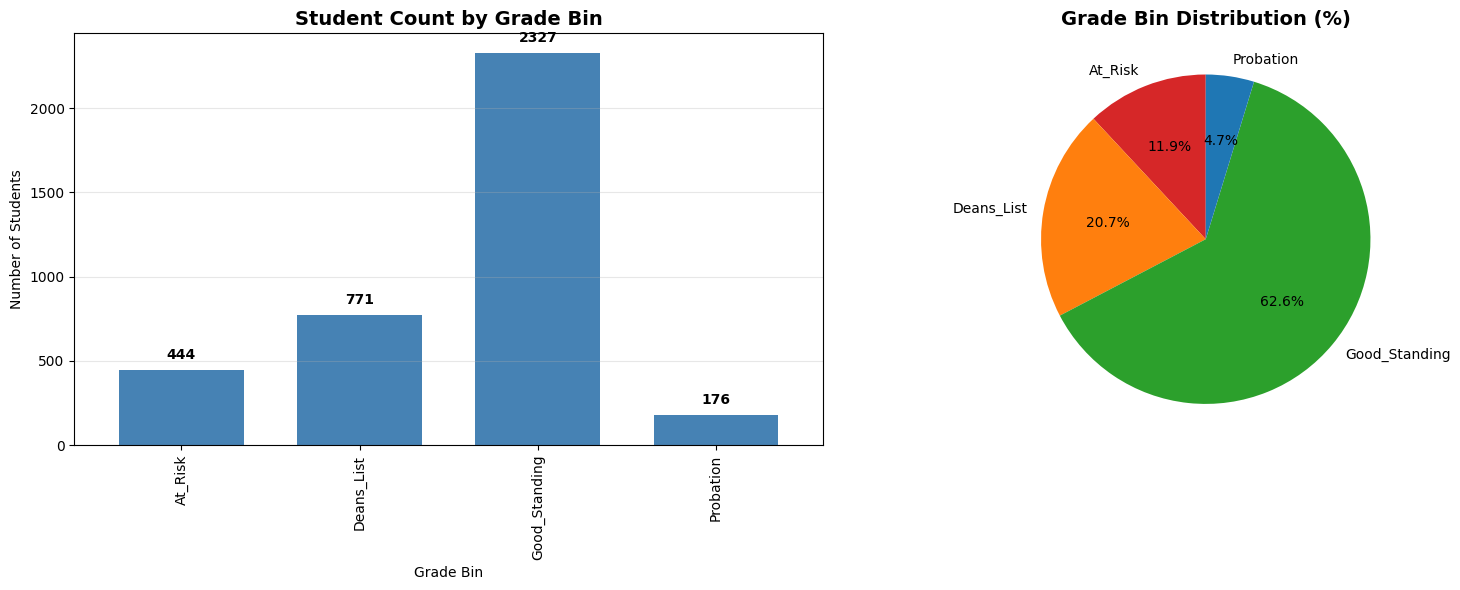

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

grade_distribution.plot(kind='bar', ax=axes[0], color='steelblue', width=0.7)
axes[0].set_title('Student Count by Grade Bin', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Grade Bin')
axes[0].set_ylabel('Number of Students')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(grade_distribution.values):
    axes[0].text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']
axes[1].pie(grade_distribution.values, labels=grade_distribution.index, autopct='%1.1f%%', 
           startangle=90, colors=colors)
axes[1].set_title('Grade Bin Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Semester-by-Semester Probation Prediction - Feasibility Assessment

**Question**: Can we build a model to predict if a student will be on probation at the end of a given semester (CGPA < 2.0)?

**Note**: Probation is determined at the END of each semester, not based on final CGPA only.

In [40]:
# Probation is determined semester-by-semester, not just final CGPA
probation_semesters = cgpa_df[cgpa_df['CGPA'] < 2.0]
non_probation_semesters = cgpa_df[cgpa_df['CGPA'] >= 2.0]

# Unique students who EVER experienced probation
students_ever_probation = probation_semesters['Student Ref'].nunique()

print("="*70)
print("SEMESTER-BY-SEMESTER PROBATION PREDICTION - FEASIBILITY")
print("="*70)
print(f"\nTotal semester records: {len(cgpa_df):,}")
print(f"Probation semesters (CGPA < 2.0): {len(probation_semesters):,}")
print(f"Non-probation semesters: {len(non_probation_semesters):,}")
print(f"Class imbalance: {len(non_probation_semesters)/len(probation_semesters):.1f}:1")
print(f"Probation rate: {len(probation_semesters)/len(cgpa_df)*100:.2f}%")

print(f"\nStudents who ever experienced probation: {students_ever_probation:,} / {cgpa_df['Student Ref'].nunique():,}")
print(f"Percentage: {students_ever_probation/cgpa_df['Student Ref'].nunique()*100:.1f}%")

print("\n" + "-"*70)
print("ASSESSMENT")
print("-"*70)

if len(probation_semesters) >= 500:
    print(f"✅ SUFFICIENT DATA: {len(probation_semesters):,} probation semester instances")
    print("   This is enough for reliable modeling")
else:
    print(f"⚠️ LIMITED DATA: Only {len(probation_semesters):,} probation instances")

if len(probation_semesters) / len(cgpa_df) < 0.10:
    print(f"⚠️ CLASS IMBALANCE: {len(probation_semesters)/len(cgpa_df)*100:.2f}% minority class")
    print("   Will require SMOTE/class weighting, but manageable")
else:
    print(f"✅ REASONABLE BALANCE: {len(probation_semesters)/len(cgpa_df)*100:.2f}% minority class")

print("\n" + "="*70)
print("VERDICT: ✅ KEEP SEMESTER-BY-SEMESTER PROBATION MODEL")
print("="*70)
print("Reasons:")
print(f"  1. Sufficient data: {len(probation_semesters):,} probation instances")
print(f"  2. Semester-level prediction is actionable (predict each semester)")
print("  3. Dataset: ~24K semester records (much more data than student-level)")
print("  4. Use case: Predict if student will be on probation at semester end")
print("="*70)

SEMESTER-BY-SEMESTER PROBATION PREDICTION - FEASIBILITY

Total semester records: 24,648
Probation semesters (CGPA < 2.0): 1,113
Non-probation semesters: 23,535
Class imbalance: 21.1:1
Probation rate: 4.52%

Students who ever experienced probation: 425 / 3,718
Percentage: 11.4%

----------------------------------------------------------------------
ASSESSMENT
----------------------------------------------------------------------
✅ SUFFICIENT DATA: 1,113 probation semester instances
   This is enough for reliable modeling
⚠️ CLASS IMBALANCE: 4.52% minority class
   Will require SMOTE/class weighting, but manageable

VERDICT: ✅ KEEP SEMESTER-BY-SEMESTER PROBATION MODEL
Reasons:
  1. Sufficient data: 1,113 probation instances
  2. Semester-level prediction is actionable (predict each semester)
  3. Dataset: ~24K semester records (much more data than student-level)
  4. Use case: Predict if student will be on probation at semester end


## 4. Academic Recovery Model - Feasibility Assessment

**Question**: For students who go on probation (CGPA < 2.0), can we predict if they'll recover to CGPA ≥ 2.0 in the NEXT semester?

**Context**: After **two consecutive semesters** on probation without achieving CGPA ≥ 2.0, students face dismissal. This model predicts if they'll exit probation after the first occurrence.

In [41]:
cgpa_df['Semester_Numeric'] = cgpa_df['Semester/Year'].map({
    'Semester 1': 1, 'Semester 2': 2, 'Semester 3': 3
})

sem2_cgpa = cgpa_df[cgpa_df['Semester_Numeric'] == 2].groupby('Student Ref')['CGPA'].first()
sem2_cgpa

Student Ref
S00039f6fd1b74390    3.88
S000901505ca1ec7f    3.72
S0021eb5e8ac9bfec    3.75
S0027200343737e85    3.53
S002e2924edb73507    2.97
                     ... 
Sffc62f216be57e22    3.71
Sffdc134559b77cd1    2.87
Sffdfdfaf71649f4f    2.29
Sfffc0eb83c36540e    2.57
Sffffe898fc7ff37b    3.03
Name: CGPA, Length: 3666, dtype: float64

In [42]:
cgpa_df['Semester_Numeric'] = cgpa_df['Semester/Year'].map({
    'Semester 1': 1, 'Semester 2': 2, 'Semester 3': 3
})

# Sort chronologically
cgpa_df_sorted = cgpa_df.sort_values(['Student Ref', 'Academic Year', 'Semester_Numeric'])

# For each student, find ALL probation instances and check recovery for each
# This tracks relapses - students can recover, fall back, and recover again
recovery_cases = []

for student_id, group in cgpa_df_sorted.groupby('Student Ref'):
    cgpas = group['CGPA'].values
    
    # Check ALL semesters for probation (not just first)
    for i, cgpa in enumerate(cgpas):
        # Found a probation semester
        if pd.notna(cgpa) and cgpa < 2.0:
            # Check if next semester exists
            if i < len(cgpas) - 1:
                next_cgpa = cgpas[i + 1]
                if pd.notna(next_cgpa):
                    recovery_cases.append({
                        'student_id': student_id,
                        'probation_semester': i + 1,
                        'probation_cgpa': cgpa,
                        'next_cgpa': next_cgpa,
                        'recovered': int(next_cgpa >= 2.0)
                    })

recovery_df = pd.DataFrame(recovery_cases)

print("="*70)
print("ACADEMIC RECOVERY MODEL - FEASIBILITY (ALL PROBATION INSTANCES)")
print("="*70)
print(f"\nTotal probation instances with next semester data: {len(recovery_df)}")

if len(recovery_df) > 0:
    # Overall statistics
    print(f"  Recovered (CGPA ≥ 2.0 next semester): {recovery_df['recovered'].sum()}")
    print(f"  Did not recover (still < 2.0): {(recovery_df['recovered'] == 0).sum()}")
    print(f"\nOverall recovery rate: {recovery_df['recovered'].mean()*100:.1f}%")
    
    # Check for students with multiple probation episodes
    students_with_multiple = recovery_df['student_id'].value_counts()
    students_with_relapses = (students_with_multiple > 1).sum()
    
    print(f"\nRelapse tracking:")
    print(f"  Unique students who went on probation: {recovery_df['student_id'].nunique()}")
    print(f"  Students with multiple probation episodes: {students_with_relapses}")
    print(f"  Students with single probation episode: {(students_with_multiple == 1).sum()}")
    print(f"  Average probation episodes per student: {students_with_multiple.mean():.2f}")
    
    # Check recovery patterns
    if students_with_relapses > 0:
        print(f"\n  Examples of students with relapses:")
        multi_probation_students = students_with_multiple[students_with_multiple > 1].head(5)
        for student, count in multi_probation_students.items():
            student_cases = recovery_df[recovery_df['student_id'] == student]
            recoveries = student_cases['recovered'].sum()
            print(f"    Student {student[:10]}...: {count} probation episodes, {recoveries} recoveries")
    
    print("\n" + "-"*70)
    print("ASSESSMENT")
    print("-"*70)
    
    if len(recovery_df) >= 100:
        print(f"✅ SAMPLE SIZE: {len(recovery_df)} recovery cases (adequate)")
    else:
        print(f"⚠️ LIMITED SAMPLE: {len(recovery_df)} recovery cases")
    
    recovery_rate = recovery_df['recovered'].mean()
    if 0.20 <= recovery_rate <= 0.80:
        print(f"✅ BALANCED: {recovery_rate*100:.1f}% recovery rate (good for modeling)")
    elif recovery_rate < 0.20:
        print(f"⚠️ LOW RECOVERY: {recovery_rate*100:.1f}% recovery rate")
        print("   Most students don't recover - still predictable")
    else:
        print(f"⚠️ HIGH RECOVERY: {recovery_rate*100:.1f}% recovery rate")
        print("   Most students recover - still predictable")
    
    print("\n" + "="*70)
    print("VERDICT: ✅ KEEP ACADEMIC RECOVERY MODEL")
    print("="*70)
    print("Reasons:")
    print(f"  1. Sufficient data: {len(recovery_df)} probation-to-next-semester cases")
    print(f"  2. TRACKS ALL INSTANCES: Including relapses ({students_with_relapses} students)")
    print("  3. CRITICAL for dismissal prevention (2 consecutive = dismissal)")
    print("  4. Actionable: Target interventions after ANY probation")
    print("  5. Clear outcome: CGPA ≥ 2.0 next semester or not")
    print("="*70)
else:
    print("\n❌ No recovery cases found - cannot build model")

ACADEMIC RECOVERY MODEL - FEASIBILITY (ALL PROBATION INSTANCES)

Total probation instances with next semester data: 937
  Recovered (CGPA ≥ 2.0 next semester): 329
  Did not recover (still < 2.0): 608

Overall recovery rate: 35.1%

Relapse tracking:
  Unique students who went on probation: 365
  Students with multiple probation episodes: 201
  Students with single probation episode: 164
  Average probation episodes per student: 2.57

  Examples of students with relapses:
    Student S52135e870...: 12 probation episodes, 1 recoveries
    Student Sba9ad51bb...: 11 probation episodes, 1 recoveries
    Student S7e97d3ee3...: 11 probation episodes, 2 recoveries
    Student S6cc8ed6c5...: 10 probation episodes, 3 recoveries
    Student S78fb4ed26...: 9 probation episodes, 3 recoveries

----------------------------------------------------------------------
ASSESSMENT
----------------------------------------------------------------------
✅ SAMPLE SIZE: 937 recovery cases (adequate)
✅ BALANCED:

## 5. Graduation Success vs Early Warning - Redundancy Check

**Question**: If we predict final grade bin (Early Warning), does that already tell us who will graduate? Or does graduation depend on additional factors?

In [43]:
student_final_data['Student_Status'].unique()

array(['Active', 'Graduated', 'Exited', 'Course Completed',
       'Leave of Absence', 'Ineligibility'], dtype=object)

In [44]:
# CORRECTED: Only analyze students who have completed their journey
# Active students are still mid-program and cannot be evaluated for graduation yet
completed_students = student_final_data[student_final_data['Student_Status'] != 'Active'].copy()

completed_students['Graduated'] = (completed_students['Student_Status'] == 'Graduated').astype(int) # ineligibility, exited, leave of absence and course completed become 0

grad_by_bin = completed_students[completed_students['Grade_Bin'] != 'Unknown'].groupby('Grade_Bin').agg({
    'Graduated': ['sum', 'count', 'mean']
}).reset_index()
grad_by_bin.columns = ['Grade_Bin', 'Graduated_Count', 'Total_Count', 'Graduation_Rate']

bin_order = ['Probation', 'At_Risk', 'Good_Standing', 'Deans_List']
grad_by_bin['Grade_Bin'] = pd.Categorical(grad_by_bin['Grade_Bin'], categories=bin_order, ordered=True)
grad_by_bin = grad_by_bin.sort_values('Grade_Bin')

print("="*70)
print("GRADUATION SUCCESS vs EARLY WARNING - CORRELATION")
print("="*70)
print(f"\nTotal students in dataset: {len(student_final_data):,}")
print(f"Active students (excluded): {(student_final_data['Student_Status'] == 'Active').sum():,}")
print(f"Completed students (analyzed): {len(completed_students):,}")
print("\nGraduation Rate by Final Grade Bin (Completed Students Only):")
print("-"*70)
for _, row in grad_by_bin.iterrows():
    print(f"{row['Grade_Bin']:15s}: {row['Graduated_Count']:4.0f}/{row['Total_Count']:4.0f} = {row['Graduation_Rate']*100:5.1f}%")

overall_grad_rate = completed_students['Graduated'].mean()
variance = grad_by_bin['Graduation_Rate'].std()

print(f"\nOverall graduation rate (completed students): {overall_grad_rate*100:.1f}%")
print(f"Std deviation across bins: {variance*100:.1f}%")
print(f"Range: {grad_by_bin['Graduation_Rate'].min()*100:.1f}% to {grad_by_bin['Graduation_Rate'].max()*100:.1f}%")

GRADUATION SUCCESS vs EARLY WARNING - CORRELATION

Total students in dataset: 3,718
Active students (excluded): 1,514
Completed students (analyzed): 2,204

Graduation Rate by Final Grade Bin (Completed Students Only):
----------------------------------------------------------------------
Probation      :    0/ 124 =   0.0%
At_Risk        :  158/ 194 =  81.4%
Good_Standing  : 1339/1392 =  96.2%
Deans_List     :  459/ 494 =  92.9%

Overall graduation rate (completed students): 88.7%
Std deviation across bins: 45.5%
Range: 0.0% to 96.2%


In [45]:
grad_by_bin.head(5)

,Grade_Bin,Graduated_Count,Total_Count,Graduation_Rate
3,Probation,0,124,0.000000
0,At_Risk,158,194,0.814433
2,Good_Standing,1339,1392,0.961925
1,Deans_List,459,494,0.929150


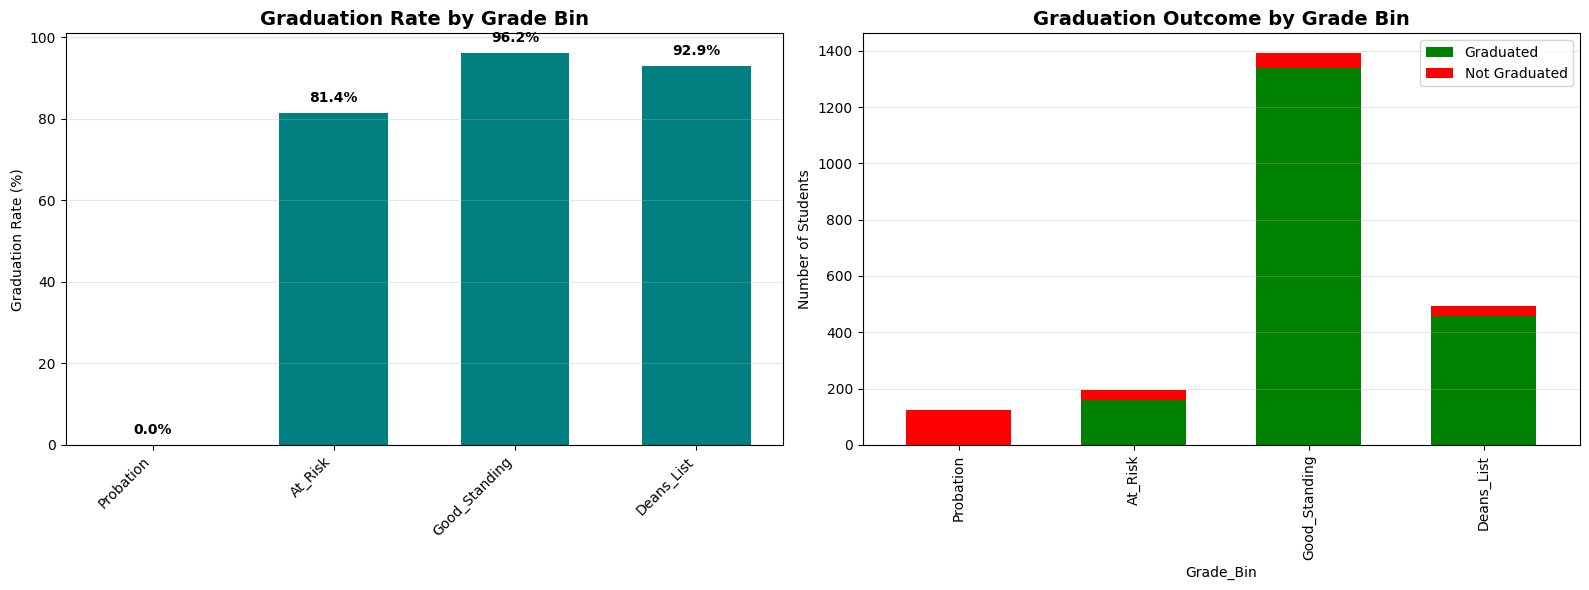

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x = np.arange(len(grad_by_bin))
axes[0].bar(x, grad_by_bin['Graduation_Rate'] * 100, color='teal', width=0.6)
axes[0].set_xticks(x)
axes[0].set_xticklabels(grad_by_bin['Grade_Bin'], rotation=45, ha='right')
axes[0].set_ylabel('Graduation Rate (%)')
axes[0].set_title('Graduation Rate by Grade Bin', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(grad_by_bin['Graduation_Rate'] * 100):
    axes[0].text(i, v + 2, f"{v:.1f}%", ha='center', va='bottom', fontweight='bold')

grad_counts = grad_by_bin[['Grade_Bin', 'Graduated_Count', 'Total_Count']].copy()
grad_counts['Not_Graduated'] = grad_counts['Total_Count'] - grad_counts['Graduated_Count']
grad_counts.set_index('Grade_Bin')[['Graduated_Count', 'Not_Graduated']].plot(
    kind='bar', stacked=True, ax=axes[1], color=['green', 'red'], width=0.6
)
axes[1].set_ylabel('Number of Students')
axes[1].set_title('Graduation Outcome by Grade Bin', fontsize=14, fontweight='bold')
axes[1].legend(['Graduated', 'Not Graduated'])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [47]:
print("\n" + "-"*70)
print("ASSESSMENT")
print("-"*70)
print("\nKey Observations:")
print("  1. Analysis restricted to COMPLETED students only (Active students excluded)")
print("  2. Student statuses included: Graduated, Exited, Ineligibility, Leave of Absence, Course Completed")
print(f"  3. Probation (< 2.0) → {grad_by_bin[grad_by_bin['Grade_Bin']=='Probation']['Graduation_Rate'].values[0]*100:.1f}% graduation")
print(f"  4. At-Risk (2.0-2.5) → {grad_by_bin[grad_by_bin['Grade_Bin']=='At_Risk']['Graduation_Rate'].values[0]*100:.1f}% graduation")
print(f"  5. Good Standing (2.5-3.5) → {grad_by_bin[grad_by_bin['Grade_Bin']=='Good_Standing']['Graduation_Rate'].values[0]*100:.1f}% graduation")
print(f"  6. Dean's List (≥ 3.5) → {grad_by_bin[grad_by_bin['Grade_Bin']=='Deans_List']['Graduation_Rate'].values[0]*100:.1f}% graduation")

range_pct = grad_by_bin['Graduation_Rate'].max() - grad_by_bin['Graduation_Rate'].min()
print(f"\nVariation across bins: {range_pct*100:.1f}% range")

print("\nInsights:")
print("  - Grade bin explains SOME graduation variation")
print("  - However, variability within bins is limited")
print("  - Most variation is already captured by grade bin predictions")
print("  - Early warning models already predict final grade bin")

print("\n" + "="*70)
print("VERDICT: ❌ DROP GRADUATION SUCCESS MODEL")
print("="*70)
print("Reasons:")
print("  1. The reasons that account for a student not graduating are not academics related and lack intepretability -ineligibility, exited, leave of absence and course completed")
print("  2. REDUNDANT: Early warning models already predict final outcomes")
print("  3. FOCUS RESOURCES: Better to focus on probation prevention & recovery")
print("  4. Insufficient added value for model complexity")
print("="*70)


----------------------------------------------------------------------
ASSESSMENT
----------------------------------------------------------------------

Key Observations:
  1. Analysis restricted to COMPLETED students only (Active students excluded)
  2. Student statuses included: Graduated, Exited, Ineligibility, Leave of Absence, Course Completed
  3. Probation (< 2.0) → 0.0% graduation
  4. At-Risk (2.0-2.5) → 81.4% graduation
  5. Good Standing (2.5-3.5) → 96.2% graduation
  6. Dean's List (≥ 3.5) → 92.9% graduation

Variation across bins: 96.2% range

Insights:
  - Grade bin explains SOME graduation variation
  - However, variability within bins is limited
  - Most variation is already captured by grade bin predictions
  - Early warning models already predict final grade bin

VERDICT: ❌ DROP GRADUATION SUCCESS MODEL
Reasons:
  1. The reasons that account for a student not graduating are not academics related and lack intepretability -ineligibility, exited, leave of absence and c

## 6. STEM Course Success - Data Availability

**Question**: Do we have enough data to build a course success predictor? Should it be CS-only or all STEM?

In [48]:
transcript_df['Grade point'] = pd.to_numeric(transcript_df['Grade point'], errors='coerce')
transcript_clean = transcript_df[transcript_df['Grade point'].notna()].copy()

cs_courses = transcript_clean[transcript_clean['Course Code'].str.contains('CS |COMP', case=False, na=False)]
math_courses = transcript_clean[transcript_clean['Course Code'].str.contains('MATH', case=False, na=False)]
engr_courses = transcript_clean[transcript_clean['Course Code'].str.contains('ENGR|MECH|ELEC', case=False, na=False)]
phys_courses = transcript_clean[transcript_clean['Course Code'].str.contains('PHYS', case=False, na=False)]
chem_courses = transcript_clean[transcript_clean['Course Code'].str.contains('CHEM', case=False, na=False)]

all_stem = pd.concat([cs_courses, math_courses, engr_courses, phys_courses, chem_courses]).drop_duplicates()

def analyze_course_category(df, name):
    if len(df) == 0:
        return None
    df['Passed'] = (df['Grade point'] >= 2.0).astype(int)
    pass_rate = df['Passed'].mean()
    return {
        'Category': name,
        'Enrollments': len(df),
        'Unique_Courses': df['Course Code'].nunique(),
        'Students': df['StudentRef'].nunique(),
        'Pass_Rate': pass_rate,
        'Fail_Rate': 1 - pass_rate,
        'Passed': df['Passed'].sum(),
        'Failed': (df['Passed'] == 0).sum()
    }

results = []
for courses, name in [(cs_courses, 'CS/COMP'), (math_courses, 'MATH'), 
                      (engr_courses, 'ENGINEERING'), (phys_courses, 'PHYSICS'),
                      (chem_courses, 'CHEMISTRY'), (all_stem, 'ALL STEM')]:
    result = analyze_course_category(courses, name)
    if result:
        results.append(result)

results_df = pd.DataFrame(results)

print("="*70)
print("STEM COURSE SUCCESS - DATA AVAILABILITY")
print("="*70)
print("\n")
print(results_df.to_string(index=False))

STEM COURSE SUCCESS - DATA AVAILABILITY


   Category  Enrollments  Unique_Courses  Students  Pass_Rate  Fail_Rate  Passed  Failed
    CS/COMP          901              23       512   0.904550   0.095450     815      86
       MATH        15745              23      3640   0.827564   0.172436   13030    2715
ENGINEERING         4683              17      1337   0.957719   0.042281    4485     198
    PHYSICS            9               6         3   0.888889   0.111111       8       1
   ALL STEM        21338              69      3640   0.859406   0.140594   18338    3000


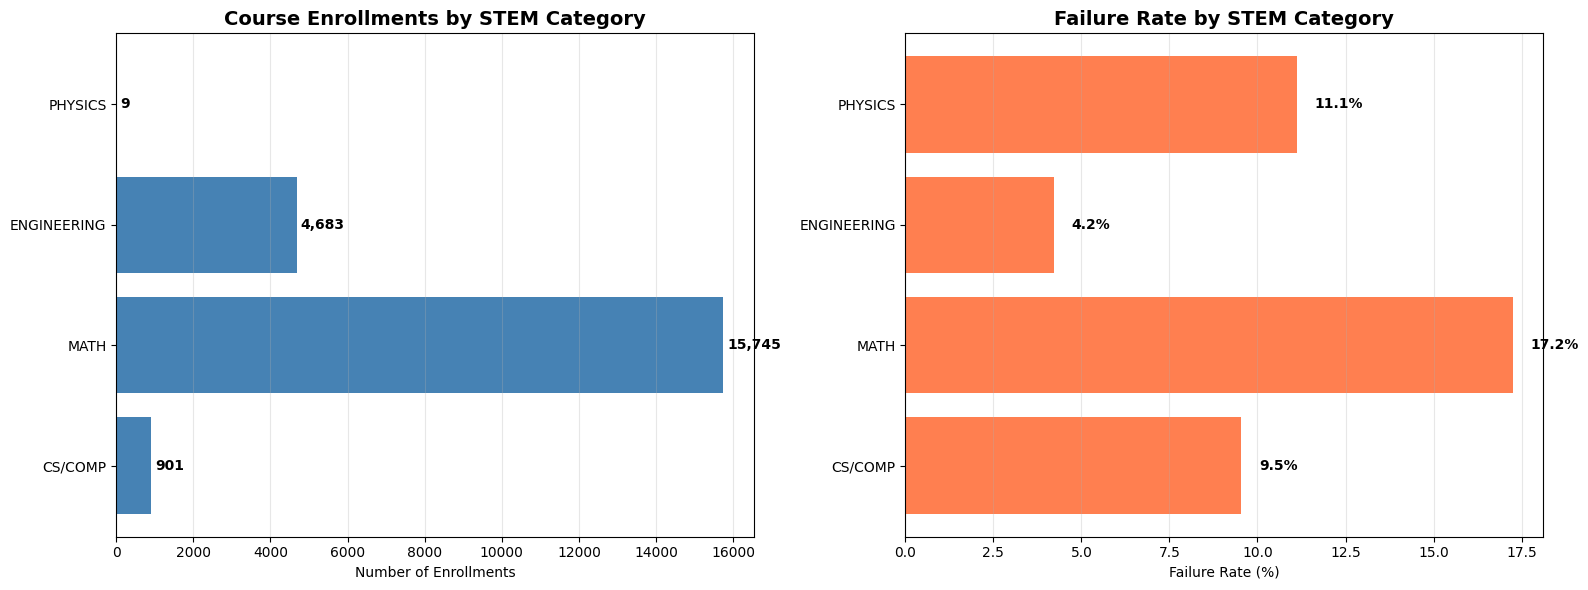

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

stem_subset = results_df[results_df['Category'] != 'ALL STEM']
axes[0].barh(stem_subset['Category'], stem_subset['Enrollments'], color='steelblue')
axes[0].set_xlabel('Number of Enrollments')
axes[0].set_title('Course Enrollments by STEM Category', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(stem_subset['Enrollments']):
    axes[0].text(v + 100, i, f"{v:,}", va='center', fontweight='bold')

axes[1].barh(stem_subset['Category'], stem_subset['Fail_Rate'] * 100, color='coral')
axes[1].set_xlabel('Failure Rate (%)')
axes[1].set_title('Failure Rate by STEM Category', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(stem_subset['Fail_Rate'] * 100):
    axes[1].text(v + 0.5, i, f"{v:.1f}%", va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [50]:
print("\n" + "-"*70)
print("ASSESSMENT")
print("-"*70)

cs_data = results_df[results_df['Category'] == 'CS/COMP'].iloc[0]
all_stem_data = results_df[results_df['Category'] == 'ALL STEM'].iloc[0]

print(f"\nCS-only model:")
print(f"  Enrollments: {cs_data['Enrollments']:.0f}")
print(f"  Failure rate: {cs_data['Fail_Rate']*100:.1f}%")
print(f"  Assessment: ⚠️ LIMITED DATA (only 900 enrollments)")
print(f"              ⚠️ HIGH PASS RATE ({cs_data['Pass_Rate']*100:.1f}%) - imbalanced")

print(f"\nAll STEM model:")
print(f"  Enrollments: {all_stem_data['Enrollments']:.0f}")
print(f"  Failure rate: {all_stem_data['Fail_Rate']*100:.1f}%")
print(f"  Assessment: ✅ SUFFICIENT DATA ({all_stem_data['Enrollments']:.0f} enrollments)")
print(f"              ✅ REASONABLE FAILURE RATE ({all_stem_data['Fail_Rate']*100:.1f}%)")

print("\n" + "="*70)
print("VERDICT: ✅ BUILD STEM COURSE SUCCESS MODEL (ALL STEM)")
print("="*70)
print("Decision:")
print("  - Expand from CS-only to ALL STEM courses")
print("  - Includes: CS, MATH, ENGINEERING, PHYSICS, CHEMISTRY")
print(f"  - Total: {all_stem_data['Enrollments']:.0f} enrollments from {all_stem_data['Students']:.0f} students")
print(f"  - Failure rate: {all_stem_data['Fail_Rate']*100:.1f}% (manageable with class balancing)")
print("  - Provides actionable advising for STEM students")
print("="*70)


----------------------------------------------------------------------
ASSESSMENT
----------------------------------------------------------------------

CS-only model:
  Enrollments: 901
  Failure rate: 9.5%
  Assessment: ⚠️ LIMITED DATA (only 900 enrollments)
              ⚠️ HIGH PASS RATE (90.5%) - imbalanced

All STEM model:
  Enrollments: 21338
  Failure rate: 14.1%
  Assessment: ✅ SUFFICIENT DATA (21338 enrollments)
              ✅ REASONABLE FAILURE RATE (14.1%)

VERDICT: ✅ BUILD STEM COURSE SUCCESS MODEL (ALL STEM)
Decision:
  - Expand from CS-only to ALL STEM courses
  - Includes: CS, MATH, ENGINEERING, PHYSICS, CHEMISTRY
  - Total: 21338 enrollments from 3640 students
  - Failure rate: 14.1% (manageable with class balancing)
  - Provides actionable advising for STEM students


## 7. Final Model Recommendations

In [51]:
print("="*70)
print("FINAL MODEL RECOMMENDATIONS")
print("="*70)

print("\n✅ MODELS TO BUILD:")
print("-"*70)
print("1. Early Warning System - First Semester")
print("   - Predict final grade bin from 1st semester GPA")
print("   - 4-class classification (Probation/At-Risk/Good/Dean's)")
print("   - HIGH IMPACT: Early intervention\n")

print("2. Early Warning System - First Year")
print("   - Predict final grade bin from full first year")
print("   - More accurate with additional data")
print("   - HIGH IMPACT: Targeted support\n")

print("3. Semester-by-Semester Probation Prediction")
print("   - Predict if student will be on probation at semester end (CGPA < 2.0)")
print("   - Binary classification at semester level (~24K records)")
print("   - TRACKS ALL INSTANCES: Students can recover and fall back")
print("   - HIGH IMPACT: Prevent academic dismissal\n")

print("4. Academic Recovery Prediction")
print("   - After FIRST probation, predict if student will recover (CGPA ≥ 2.0 next semester)")
print("   - CRITICAL: 2 consecutive probation semesters → dismissal")
print("   - HIGH IMPACT: Target interventions after first probation\n")

print("5. Next Semester GPA Change")
print("   - Predict GPA change next semester (regression)")
print("   - Positive output = improvement expected")
print("   - MEDIUM IMPACT: Progress monitoring\n")

print("6. STEM Course Success Predictor")
print("   - Predict if student will pass STEM course (binary)")
print("   - All STEM: CS, Math, Engineering, Physics, Chemistry")
print("   - MEDIUM IMPACT: Course selection advising\n")




FINAL MODEL RECOMMENDATIONS

✅ MODELS TO BUILD:
----------------------------------------------------------------------
1. Early Warning System - First Semester
   - Predict final grade bin from 1st semester GPA
   - 4-class classification (Probation/At-Risk/Good/Dean's)
   - HIGH IMPACT: Early intervention

2. Early Warning System - First Year
   - Predict final grade bin from full first year
   - More accurate with additional data
   - HIGH IMPACT: Targeted support

3. Semester-by-Semester Probation Prediction
   - Predict if student will be on probation at semester end (CGPA < 2.0)
   - Binary classification at semester level (~24K records)
   - TRACKS ALL INSTANCES: Students can recover and fall back
   - HIGH IMPACT: Prevent academic dismissal

4. Academic Recovery Prediction
   - After FIRST probation, predict if student will recover (CGPA ≥ 2.0 next semester)
   - CRITICAL: 2 consecutive probation semesters → dismissal
   - HIGH IMPACT: Target interventions after first probation


In [52]:
summary_data = {
    'Model': [
        'Early Warning (1st Semester)',
        'Early Warning (1st Year)',
        'Semester Probation Prediction',
        'Academic Recovery',
        'Next Semester GPA Change',
        'STEM Course Success'
    ],
    'Type': [
        'Multi-class Classification',
        'Multi-class Classification',
        'Binary Classification',
        'Binary Classification',
        'Regression',
        'Binary Classification'
    ],
    'Status': ['✅ Build'] * 6,
    'Impact': ['High', 'High', 'High', 'High', 'Medium', 'Medium'],
    'Sample_Size': [
        f'{len(student_final_data):,} students',
        f'{len(student_final_data):,} students',
        f'{len(probation_semesters):,} probation cases',
        f'{len(recovery_df)} recovery cases',
        f'~{len(cgpa_df):,} semester transitions',
        f'{all_stem_data["Enrollments"]:.0f} enrollments'
    ]
}

dropped_data = {
    'Model': [
        'Graduation Success',
        'Time-to-Degree',
        'Retention/Dropout'
    ],
    'Type': [
        'Binary Classification',
        'Regression',
        'Binary Classification'
    ],
    'Status': ['❌ Drop'] * 3,
    'Reason': [
        'Low variability - grade bins predict outcomes',
        'Not critical for interventions',
        'Redundant with other models'
    ]
}

summary_df = pd.DataFrame(summary_data)
dropped_df = pd.DataFrame(dropped_data)

print("\nMODELS TO BUILD:")
print(summary_df.to_string(index=False))
print("\nMODELS DROPPED:")
print(dropped_df.to_string(index=False))

print("\n" + "="*70)
print("✅ CORRECTED ANALYSIS COMPLETE")
print("="*70)
print("Key Corrections:")
print("  1. Probation: Tracks ALL semester instances (recover & relapse)")
print("     - Features: num_prior_probations, last_sem_on_probation, recovered_before")
print("  2. Academic Recovery: First probation → next semester recovery")
print("  3. Graduation: Dropped due to low variability")
print("\nProceed with feature engineering for 6 models.")
print("="*70)


MODELS TO BUILD:
                        Model                       Type  Status Impact                  Sample_Size
 Early Warning (1st Semester) Multi-class Classification ✅ Build   High               3,718 students
     Early Warning (1st Year) Multi-class Classification ✅ Build   High               3,718 students
Semester Probation Prediction      Binary Classification ✅ Build   High        1,113 probation cases
            Academic Recovery      Binary Classification ✅ Build   High           937 recovery cases
     Next Semester GPA Change                 Regression ✅ Build Medium ~24,648 semester transitions
          STEM Course Success      Binary Classification ✅ Build Medium            21338 enrollments

MODELS DROPPED:
             Model                  Type Status                                        Reason
Graduation Success Binary Classification ❌ Drop Low variability - grade bins predict outcomes
    Time-to-Degree            Regression ❌ Drop                Not cri